In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
tf.__version__
keras.__version__

'2.7.0'

In [2]:
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
test_labels = pd.read_csv('test_labels.csv')
test_labels.head()

y_test = test.loc[:,'comment_text']
print(y_test.shape)
print(y_test)

x_test = test_labels.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
print(x_test.shape)
print(x_test)

(153164,)
0         Yo bitch Ja Rule is more succesful then you'll...
1         == From RfC == \n\n The title is fine as it is...
2         " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3         :If you have a look back at the source, the in...
4                 I don't anonymously edit articles at all.
                                ...                        
153159    . \n i totally agree, this stuff is nothing bu...
153160    == Throw from out field to home plate. == \n\n...
153161    " \n\n == Okinotorishima categories == \n\n I ...
153162    " \n\n == ""One of the founding nations of the...
153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 153164, dtype: object
(153164, 6)
        toxic  severe_toxic  obscene  threat  insult  identity_hate
0          -1            -1       -1      -1      -1             -1
1          -1            -1       -1      -1      -1             -1
2          -1            -1       -1      -1      -1            

In [4]:
train = pd.read_csv('train.csv')
#train.head()

y_train = train['comment_text'].values
x_trainLabels = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]
x_train = train[x_trainLabels].values
print(y_train)
print(x_train)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [5]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(y_train))

seq = tokenizer.texts_to_sequences(y_train)
pad = sequence.pad_sequences(seq, maxlen=100)

In [6]:
from sklearn.model_selection import train_test_split

trainData, testData, trainLabel, testLabel = train_test_split(x_train, y_train, test_size=.2, random_state=0)

In [7]:
test = test['comment_text'].values
test_seq = tokenizer.texts_to_sequences(test)
test_pad = sequence.pad_sequences(test_seq, maxlen=100)

In [8]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

input = keras.layers.Input(shape=[100,])
embed = keras.layers.Embedding(20000,128)(input)
bidirectional = keras.layers.Bidirectional(LSTM(50))(embed)
drop1 = keras.layers.Dropout(0.1)(bidirectional)
dense1 = keras.layers.Dense(50, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.1)(dense1)
output = keras.layers.Dense(6, activation="sigmoid")(drop2)
model = keras.Model(inputs=[input], outputs=[output])

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              71600     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                             

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

with tf.device("/device:GPU:1"):
    history = model.fit(pad, x_train, batch_size=32, epochs=2, validation_split=0.1, callbacks=early)

#history = model.fit(trainData, trainLabel, epochs=30, validation_data=(x_test, y_test))

Epoch 1/2
4488/4488 [==============================] - 275s 61ms/step - loss: 0.0642 - accuracy: 0.9611 - val_loss: 0.0506 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 374s 83ms/step - loss: 0.0459 - accuracy: 0.9887 - val_loss: 0.0489 - val_accuracy: 0.9940


In [10]:
y_proba = model.predict(test_pad, batch_size=1024, verbose=1)
print(y_proba)
model.evaluate(test_pad, x_test, batch_size=32, verbose=2)

150/150 [==============================] - 43s 270ms/step
[[9.9602079e-01 2.0094967e-01 9.6072388e-01 9.0085566e-03 7.4036956e-01
  5.7566702e-02]
 [1.0940731e-03 7.3021027e-07 1.0978536e-04 3.3353617e-06 1.4755130e-04
  1.4241241e-05]
 [4.5450032e-03 4.2790475e-06 4.7692657e-04 2.1199079e-05 5.8734417e-04
  7.8446290e-05]
 ...
 [4.3523610e-03 8.0945438e-06 5.8281422e-04 3.2968102e-05 7.2625279e-04
  1.1745698e-04]
 [2.3906529e-03 7.8725077e-07 1.5121698e-04 5.0918611e-06 2.1156669e-04
  2.1712069e-05]
 [9.8343658e-01 1.0046226e-01 8.9887404e-01 4.9400032e-03 6.0669422e-01
  4.1567951e-02]]
4787/4787 - 68s - loss: -3.3004e+00 - accuracy: 0.9990 - 68s/epoch - 14ms/step


[-3.300426721572876, 0.9989749789237976]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              54000     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                           

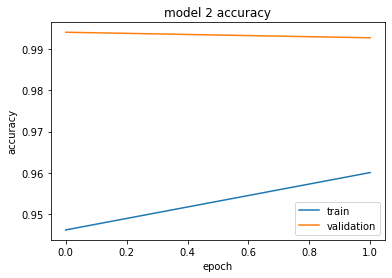

In [11]:
from keras.layers import GRU
import matplotlib.pyplot as plt

# NN 2

input = keras.layers.Input(shape=[100,])
embed = keras.layers.Embedding(20000,128)(input)
bidirectional = keras.layers.Bidirectional(GRU(50))(embed)
flat = keras.layers.Flatten(input_shape=[100,])(bidirectional)
drop1 = keras.layers.Dropout(0.1)(bidirectional)
dense1 = keras.layers.Dense(50, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.1)(dense1)
output = keras.layers.Dense(6, activation="sigmoid")(drop2)
model2 = keras.Model(inputs=[input], outputs=[output])

model2.summary()

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with tf.device("/device:GPU:1"):
    history2 = model2.fit(pad, x_train, batch_size=32, epochs=2, validation_split=0.2, callbacks=early)

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 128)     2560000     ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100)         71600       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 100)         54000       ['embedding_2[0][0]']      

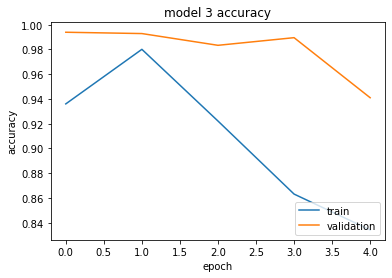

In [12]:
# NN 3

input = keras.layers.Input(shape=[100,])
embed = keras.layers.Embedding(20000,128)(input)
bi1 = keras.layers.Bidirectional(LSTM(50))(embed)
bi2 = keras.layers.Bidirectional(GRU(50))(embed)
concat = keras.layers.Concatenate()([bi1, bi2])
flat = keras.layers.Flatten(input_shape=[100,])(concat)
drop1 = keras.layers.Dropout(0.1)(flat)
dense1 = keras.layers.Dense(50, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.1)(dense1)
output = keras.layers.Dense(6, activation="sigmoid")(drop2)
model3 = keras.Model(inputs=[input], outputs=[output])

model3.summary()

model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with tf.device("/device:GPU:1"):
    history3 = model3.fit(pad, x_train, batch_size=32, epochs=5, validation_split=0.2, callbacks=early)

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 128)     2560000     ['input_4[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 200)         183200      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 200)         138000      ['embedding_3[0][0]']      

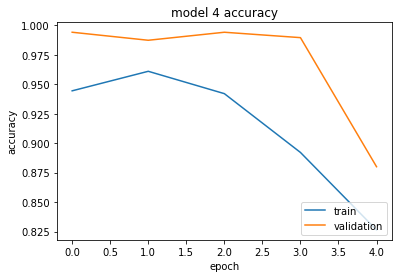

In [13]:
# NN 4

input = keras.layers.Input(shape=[100,])
embed = keras.layers.Embedding(20000,128)(input)
bi1 = keras.layers.Bidirectional(LSTM(100))(embed)
bi2 = keras.layers.Bidirectional(GRU(100))(embed)
concat = keras.layers.Concatenate()([bi1, bi2])
flat = keras.layers.Flatten(input_shape=[100,])(concat)
drop1 = keras.layers.Dropout(0.1)(flat)
dense1 = keras.layers.Dense(50, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.1)(dense1)
output = keras.layers.Dense(6, activation="sigmoid")(drop2)
model4 = keras.Model(inputs=[input], outputs=[output])

model4.summary()

model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with tf.device("/device:GPU:1"):
    history4 = model4.fit(pad, x_train, batch_size=32, epochs=5, validation_split=0.2, callbacks=early)

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model 4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 128)     2560000     ['input_5[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 200)         183200      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 200)         138000      ['embedding_4[0][0]']      

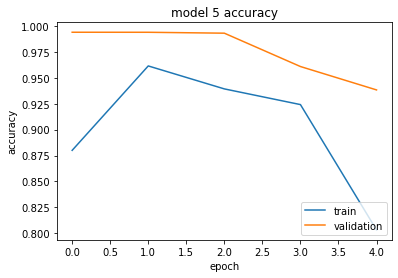

In [14]:
# NN 5

input = keras.layers.Input(shape=[100,])
embed = keras.layers.Embedding(20000,128)(input)
bi1 = keras.layers.Bidirectional(LSTM(100))(embed)
bi2 = keras.layers.Bidirectional(GRU(100))(embed)
concat = keras.layers.Concatenate()([bi1, bi2])
flat = keras.layers.Flatten(input_shape=[100,])(concat)
drop1 = keras.layers.Dropout(0.1)(flat)
dense1 = keras.layers.Dense(50, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.1)(dense1)
output = keras.layers.Dense(6, activation="sigmoid")(drop2)
model5 = keras.Model(inputs=[input], outputs=[output])

model5.summary()

model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with tf.device("/device:GPU:1"):
    history5 = model5.fit(pad, x_train, batch_size=128, epochs=5, validation_split=0.2, callbacks=early)

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model 5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')